<summary>Table of Contents</summary>

- [1. UTC to local time](#1-utc-to-local-time)
- [2. Split and scale data](#2-split-and-scale-data)



Here we split the whole dataset into 5 datasets for each country (now they contain only their country related columns). In addition we scale the data for ARIMA and persistence method, because other models do that within the code. 

# 1. UTC to local time

In [2]:
import pandas as pd
import numpy as np
import os
from datetime import date
from feature_engine.selection import DropHighPSIFeatures
from utils.helper import split_scale_dataset
from utils.descriptive_analysis import plot_daily_boxplots, multiple_hist_plots

In [2]:
# Create a folder named "datasets" if it doesn't exist
folder_name = "datasets"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

df = pd.read_csv("./datasets/top_5_countries.csv", index_col=0, parse_dates=True)

For each country revert UTC time to local time. Then make so that each dataset starts and ends at the same time.

In [3]:
top_5_countries = ['DE', 'GB', 'ES', 'FR', 'IT']
utc_converter = {'DE': 'Europe/Berlin', 
                 'GB': 'Europe/London', 
                 'ES': 'Europe/Madrid', 
                 'FR': 'Europe/Paris', 
                 'IT': 'Europe/Rome'}

# Split and save the datasets
for country_prefix in top_5_countries:
    # Filter columns with the specified prefix
    country_columns = [col for col in df.columns if col.startswith(country_prefix)]
    country_df = df[country_columns].copy()

    # Convert UTC to local time
    country_df.index = country_df.index.tz_convert(utc_converter[country_prefix]).tz_localize(None)
    
    # We drop first day and last day, because of missing values
    first_day = country_df.index.date.min()
    last_day = date(2020, 9, 30)

    # Drop all observations from the first and last days
    country_df = country_df[(country_df.index.date > first_day) & (country_df.index.date < last_day)]

    # Make 24 hours in each day (after daylight savings time etc) we have 23/25 hours
    # in other words - irregular intervals.
    # We will change it to have 24 hours in each day (simplest method). Then we do not break 
    # seasonalities and patterns, because at night load is small.
    # Time changes: https://stats.stackexchange.com/questions/45046/daylight-saving-time-in-time-series-modelling-e-g-load-data
    
    # Remove duplicated timestamps
    country_df = country_df[~country_df.index.duplicated(keep='first')]

    # Resample to hourly frequency to ensure all hours are included
    country_df = country_df.resample('H').asfreq()

    # Fill missing values with average of the previous and next value
    country_df = country_df.interpolate(method='linear', limit=1)
    
    # Save the DataFrame to a CSV file
    file_name = f"./datasets/{country_prefix}_data.csv"
    country_df.to_csv(file_name)

# 2. Split and scale data

Because of summer and winter time changes, we have not full days now.

In [4]:
de_df, gb_df, es_df, fr_df, it_df = [pd.read_csv(f"./datasets/{country}_data.csv", index_col=0, parse_dates=True) for country in top_5_countries] 

In [5]:
for df_country in [de_df, gb_df, es_df, fr_df, it_df]: 
    print(len(df_country))
del df_country

41616
41616
41616
41616
41616


In [6]:
# Check whether our data preparation was correct
# There were different indices in the datasets
# Because Britain has British summer time, others Central European summer time
# British: change time from 01:00 to 02:00
# Central European: change time from 02:00 to 03:00
# Source: https://www.timeanddate.com/time/europe/

if de_df.index.isin(gb_df.index).all():
    print("Indices are identical!")
else:
    print("Indices are not identical...")

    # Find non-matching elements
    non_matching_elements_in_de_df = de_df.index[~de_df.index.isin(gb_df.index)]
    non_matching_elements_in_gb_df = gb_df.index[~gb_df.index.isin(de_df.index)]
    print("Non-matching elements in de_df:", non_matching_elements_in_de_df)
    print("Non-matching elements in gb_df:", non_matching_elements_in_gb_df)

Indices are identical!


In [7]:
# days in the datasets
for df_country in [de_df, gb_df, es_df, fr_df, it_df]:
    days_in_data = len(df_country)/24
    print(f'{days_in_data:.0f} days in the dataset.')

del df_country

1734 days in the dataset.
1734 days in the dataset.
1734 days in the dataset.
1734 days in the dataset.
1734 days in the dataset.


In [8]:
# We combine dfs, because it will be easier to work with them
combined_df = pd.concat([de_df, gb_df, es_df, fr_df, it_df], axis=1)

print('Index frequency before:', combined_df.index.freq)

# Set frequency
combined_df = combined_df.asfreq('H')
print('Index frequency after:', combined_df.index.freq)

Index frequency before: None
Index frequency after: <Hour>


In [9]:
# Divide data into days

train_size = int(round(len(country_df)/24*0.7, 0))
test_size = int(round(len(country_df)/24*0.15, 0))
val_size = int(len(country_df)/24) - train_size - test_size
print(f'{train_size:.0f} days in the train dataset.\n {test_size:.0f} days in the test dataset.\n {val_size:.0f} days in the validation dataset.')

assert(days_in_data == train_size + test_size + val_size)

1214 days in the train dataset.
 260 days in the test dataset.
 260 days in the validation dataset.


In [10]:
num_train = train_size*24
num_test = test_size*24
num_vali = val_size*24
print(f'{num_train} observations in the train dataset.\n {num_test} observations in the test dataset.\n {num_vali} observations in the validation dataset.')

assert(len(country_df) == num_train + num_test + num_vali)

29136 observations in the train dataset.
 6240 observations in the test dataset.
 6240 observations in the validation dataset.


Split and scale datasets.

In [11]:
train, vali, test = split_scale_dataset(combined_df, train_split=0.7, test_split=0.15, scaler_type='minmax')

29136 observations in the train dataset.
6240 observations in the validation dataset. 
6240 observations in the test dataset.


In [12]:
descr = train.describe()
descr = descr.loc[['mean', 'std']].round(2)
descr.T.to_excel("./datasets/descr_train.xlsx")

In [13]:
descr.T

,mean,std
DE_load_actual_entsoe_transparency,0.54,0.22
DE_solar_generation_actual,0.14,0.22
DE_wind_generation_actual,0.26,0.20
DE_wind_offshore_generation_actual,0.33,0.24
DE_wind_onshore_generation_actual,0.24,0.20
GB_UKM_load_actual_entsoe_transparency,0.61,0.14
GB_UKM_solar_generation_actual,0.13,0.20
GB_UKM_wind_generation_actual,0.33,0.21
GB_UKM_wind_offshore_generation_actual,0.31,0.21
GB_UKM_wind_onshore_generation_actual,0.31,0.20


In [14]:
descr_test = test.describe()
descr_test = descr_test.loc[['mean', 'std']].round(2)
descr_test.T.to_excel("./datasets/descr_test.xlsx")

In [15]:
diff = descr_test - descr
diff.T.to_excel("./datasets/diff.xlsx")

In [16]:
descr_vali = vali.describe()
descr_vali = descr_vali.loc[['mean', 'std']].round(2)
descr_vali

,DE_load_actual_entsoe_transparency,DE_solar_generation_actual,DE_wind_generation_actual,DE_wind_offshore_generation_actual,DE_wind_onshore_generation_actual,GB_UKM_load_actual_entsoe_transparency,GB_UKM_solar_generation_actual,GB_UKM_wind_generation_actual,GB_UKM_wind_offshore_generation_actual,GB_UKM_wind_onshore_generation_actual,ES_load_actual_entsoe_transparency,ES_solar_generation_actual,ES_wind_onshore_generation_actual,FR_load_actual_entsoe_transparency,FR_solar_generation_actual,FR_wind_onshore_generation_actual,IT_load_actual_entsoe_transparency,IT_solar_generation_actual,IT_wind_onshore_generation_actual
mean,0.51,0.17,0.28,0.47,0.25,0.56,0.14,0.39,0.44,0.32,0.44,0.31,0.32,0.31,0.21,0.27,0.47,0.21,0.28
std,0.21,0.25,0.20,0.30,0.19,0.14,0.22,0.23,0.30,0.19,0.19,0.35,0.20,0.15,0.29,0.21,0.22,0.29,0.21


In [17]:
data = combined_df.copy()
# number of days 
train_size = int(round(len(data)/24*0.7, 0))
test_size = int(round(len(data)/24*(1-0.7-0.15), 0))

# calculate number of observations in each dataset
num_train = train_size*24
num_test = test_size*24
num_vali = len(data) - num_train - num_test 

# split data into datasets
train_data = data.iloc[:num_train] # 0, a-1
vali_data = data.iloc[num_train: num_train + num_vali] # a, a+b-1
test_data = data.iloc[num_train + num_vali:] # a+b

In [18]:
test

,DE_load_actual_entsoe_transparency,DE_solar_generation_actual,DE_wind_generation_actual,DE_wind_offshore_generation_actual,DE_wind_onshore_generation_actual,GB_UKM_load_actual_entsoe_transparency,GB_UKM_solar_generation_actual,GB_UKM_wind_generation_actual,GB_UKM_wind_offshore_generation_actual,GB_UKM_wind_onshore_generation_actual,ES_load_actual_entsoe_transparency,ES_solar_generation_actual,ES_wind_onshore_generation_actual,FR_load_actual_entsoe_transparency,FR_solar_generation_actual,FR_wind_onshore_generation_actual,IT_load_actual_entsoe_transparency,IT_solar_generation_actual,IT_wind_onshore_generation_actual
date,,,,,,,,,,,,,,,,,,,
2020-01-14 00:00:00,0.483435,0.000000,0.716752,0.955350,0.659521,0.417974,0.000000,0.870886,1.163086,0.600449,0.468490,0.002935,0.508920,0.516332,0.000000,0.921454,0.307541,0.000094,0.060961
2020-01-14 01:00:00,0.446975,0.000000,0.760245,0.948778,0.709055,0.412351,0.000000,0.817592,1.111900,0.553060,0.368190,0.002762,0.536516,0.480614,0.000000,0.922040,0.264147,0.000094,0.061694
2020-01-14 02:00:00,0.416029,0.000000,0.800222,0.964954,0.751310,0.397511,0.000000,0.805604,1.103867,0.540146,0.316014,0.002762,0.540789,0.461526,0.000000,0.922626,0.240979,0.000094,0.067116
2020-01-14 03:00:00,0.426258,0.000000,0.826340,0.976580,0.778760,0.386663,0.000000,0.802245,1.104801,0.534531,0.297330,0.003108,0.530628,0.423570,0.000000,0.933596,0.241848,0.000094,0.079865
2020-01-14 04:00:00,0.459236,0.000000,0.831769,0.970008,0.785791,0.365510,0.000000,0.780484,1.074538,0.520831,0.291407,0.003108,0.508978,0.412389,0.000000,0.923966,0.250644,0.000000,0.073857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-29 19:00:00,0.701786,0.000067,0.061802,0.117944,0.051671,0.720353,0.000888,0.200428,0.170372,0.211230,0.470276,0.282977,0.092547,0.373728,0.033962,0.052504,0.645086,0.000000,0.123828
2020-09-29 20:00:00,0.638446,0.000000,0.060311,0.083741,0.055049,0.675272,0.000222,0.247767,0.184196,0.272544,0.566526,0.121892,0.097974,0.357004,0.022013,0.051415,0.602056,0.000000,0.105657
2020-09-29 21:00:00,0.550755,0.000000,0.052970,0.054086,0.051199,0.575259,0.000222,0.268077,0.148888,0.323638,0.550237,0.105663,0.090757,0.294886,0.021698,0.056858,0.517145,0.000000,0.083675


Test set starts from Tuesday.

In [19]:
list(test.index.dayofweek)[0:24]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Extract indices for seasons from the test set.

In [20]:
#from utils.descriptive_analysis import get_season
#test['season'] = test.index.month.map(get_season)
#test.reset_index(inplace=True)

In [21]:
# Group the DataFrame by season and find the first and last index positions
#season_groups = test.groupby('season')
#season_start_end = season_groups.apply(lambda x: (x.index[0], x.index[-1]))

# Extract the numerical index values
#for season, (start_index, end_index) in season_start_end.items():
#    print(f"Season: {season}")
#    print(f"Start Index: {start_index}")
#    print(f"End Index: {end_index}")
#    print()

Distributions and variance per day of week.

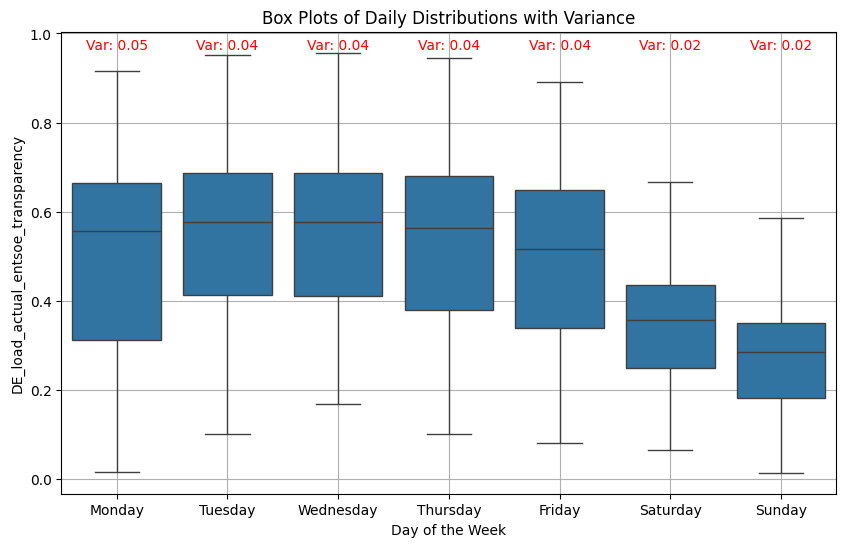

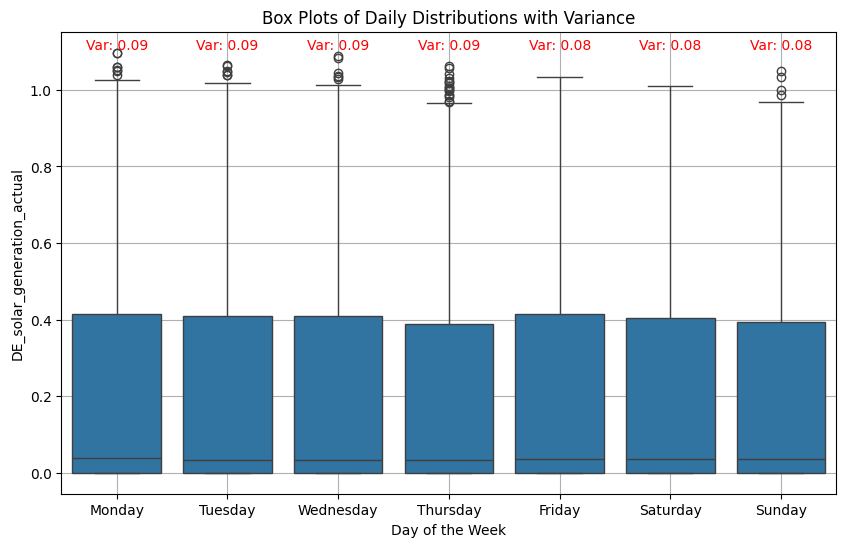

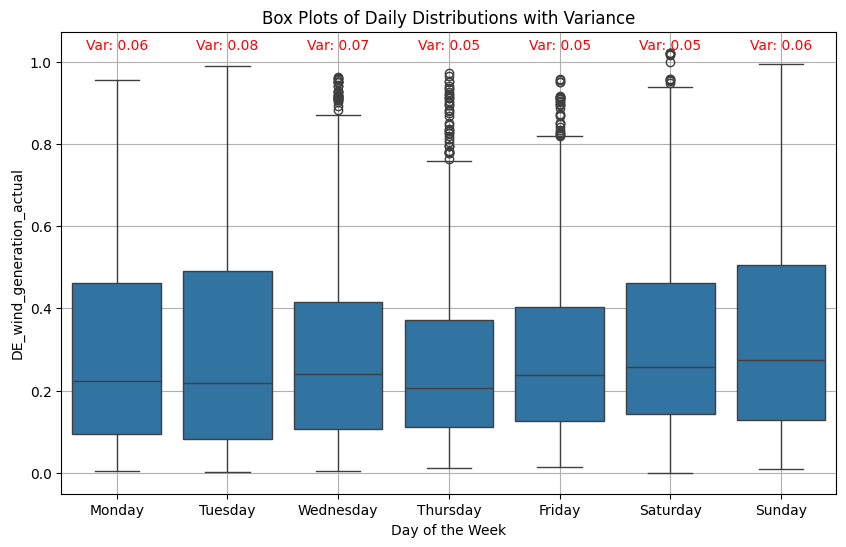

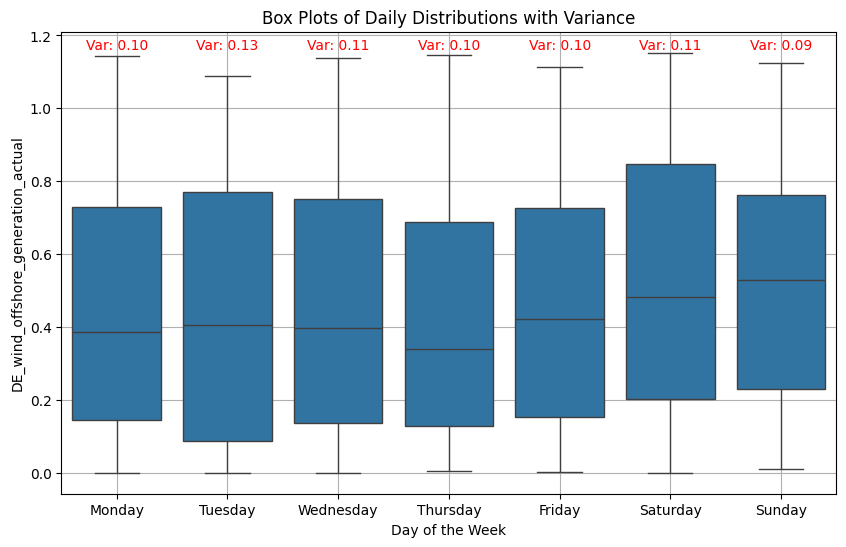

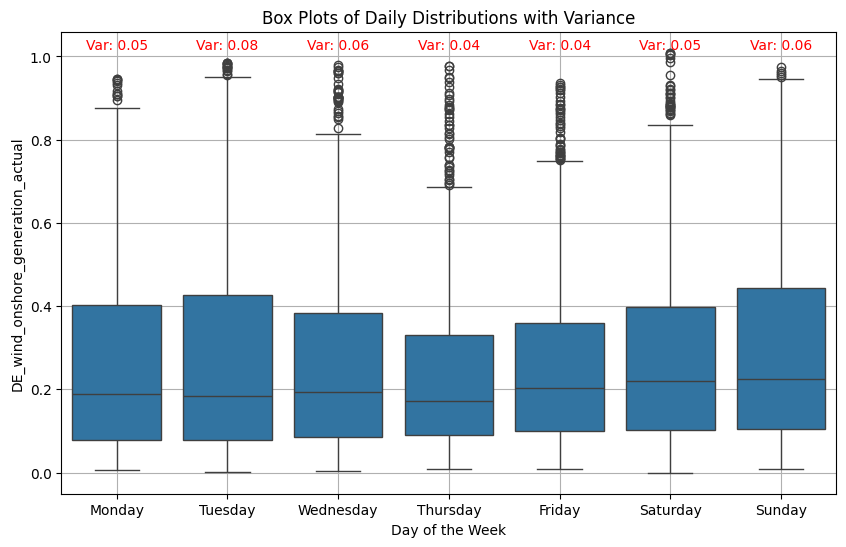

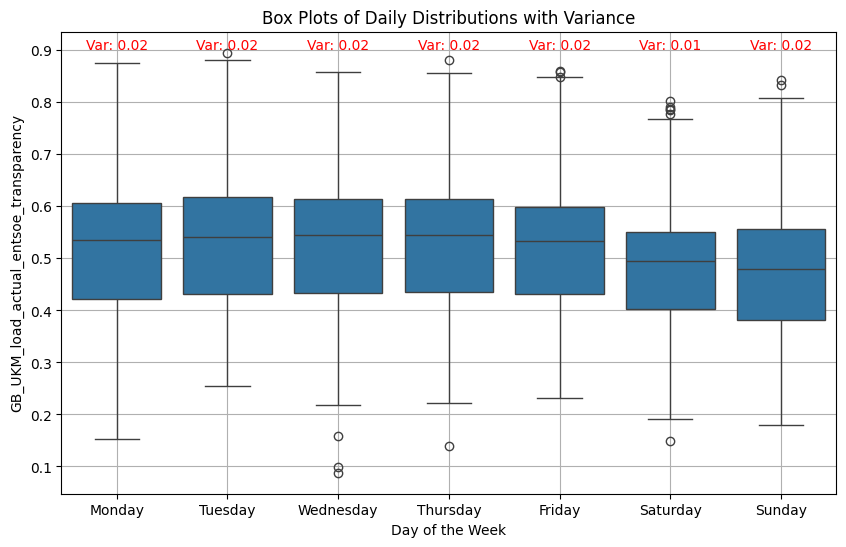

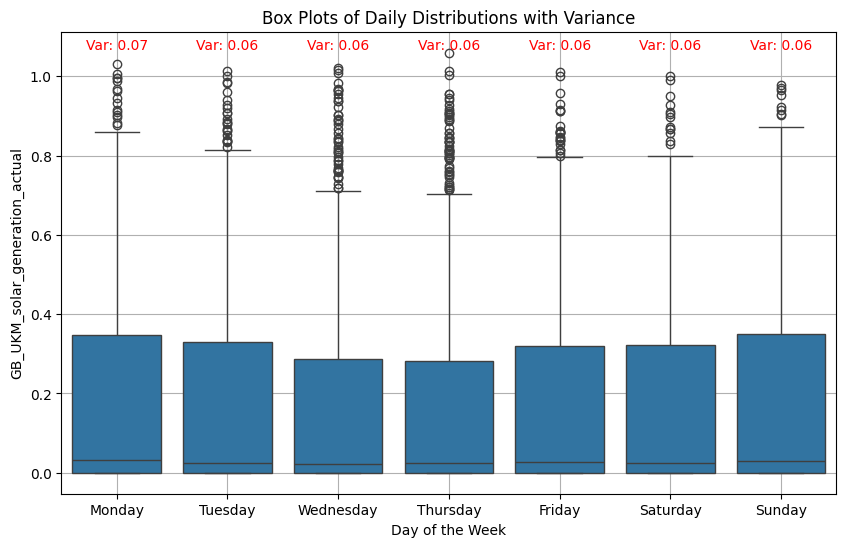

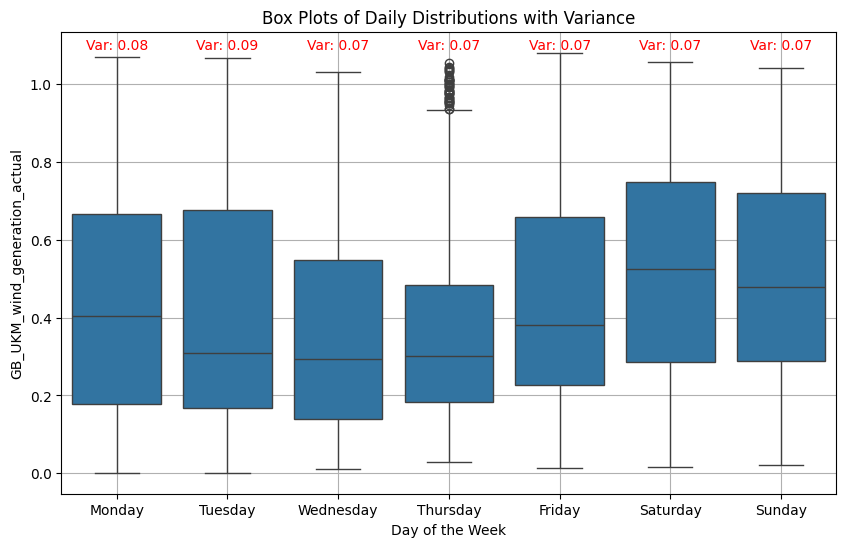

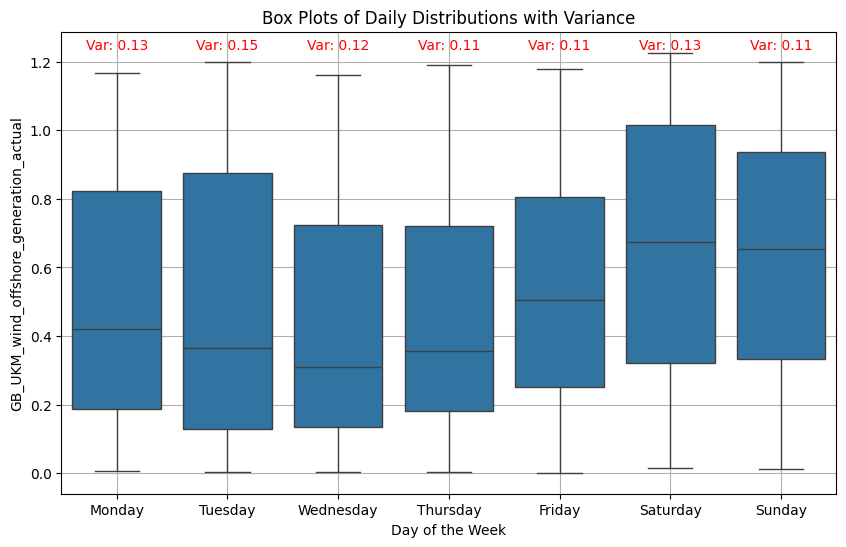

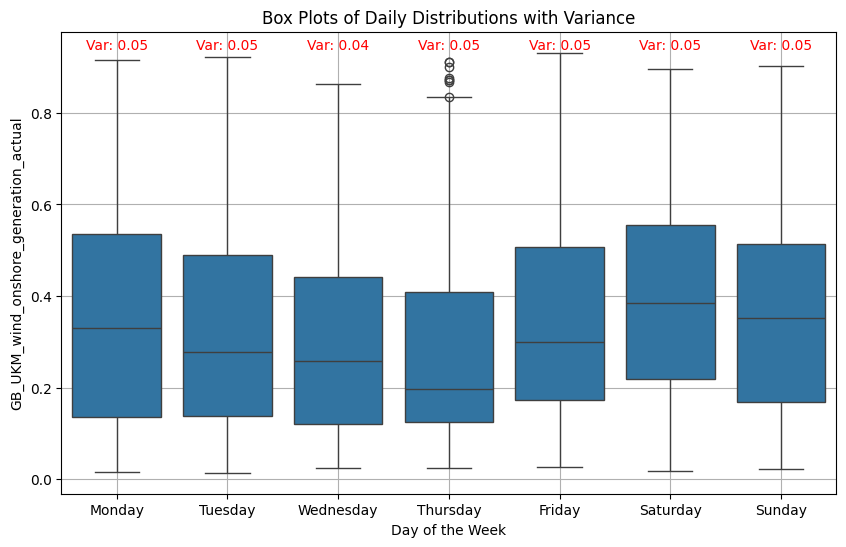

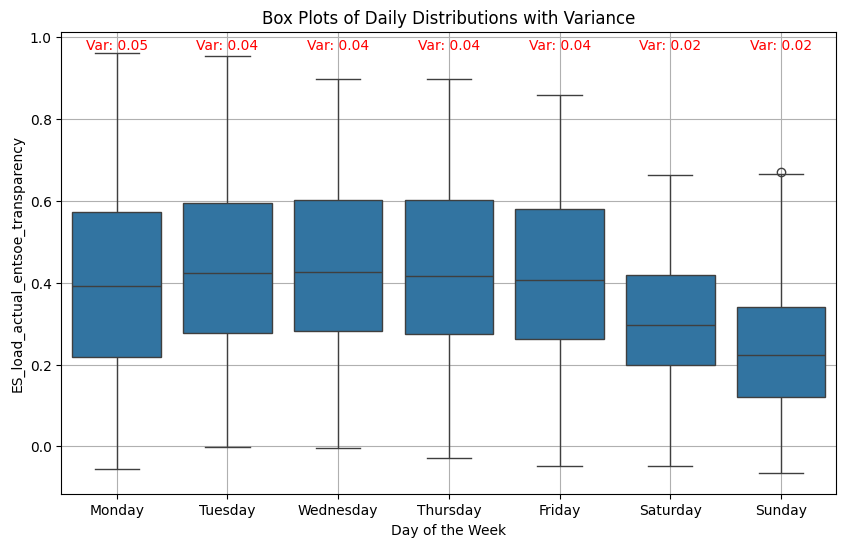

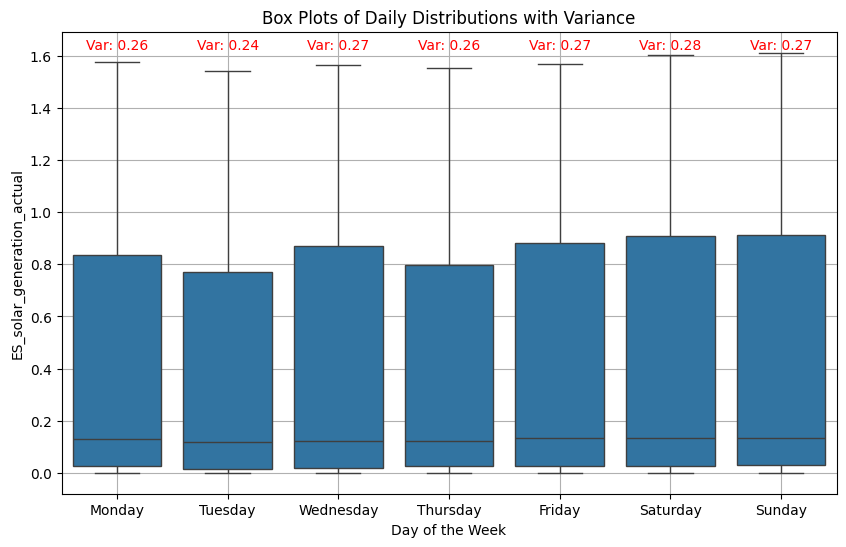

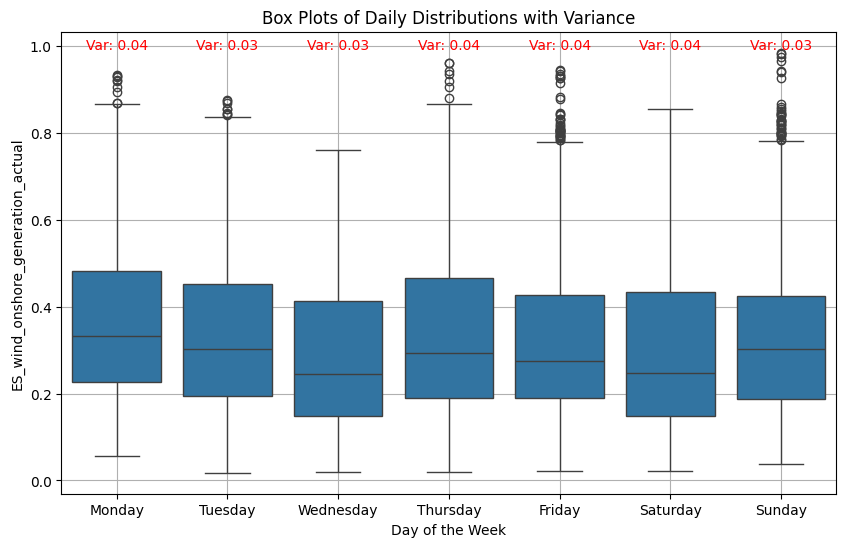

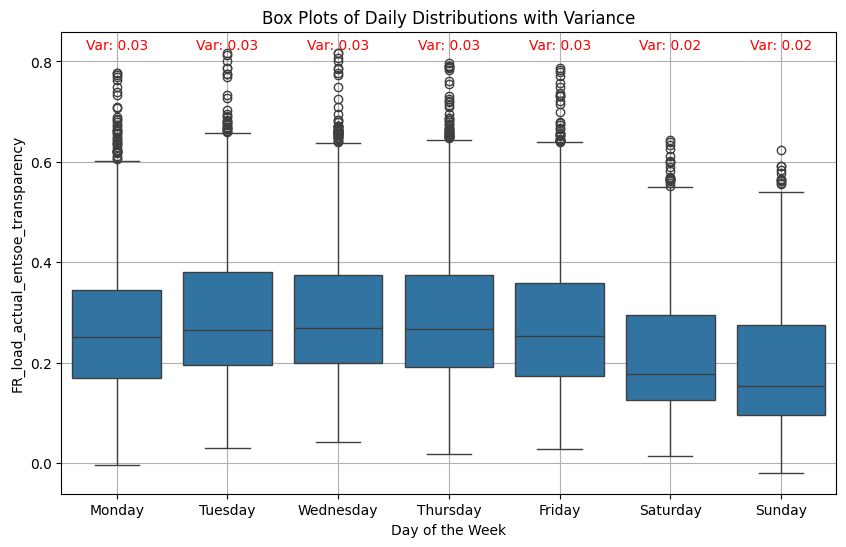

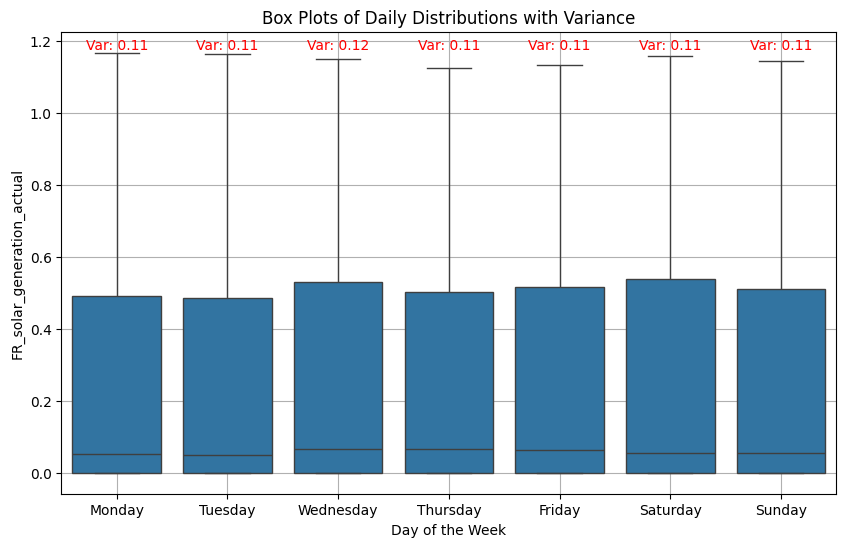

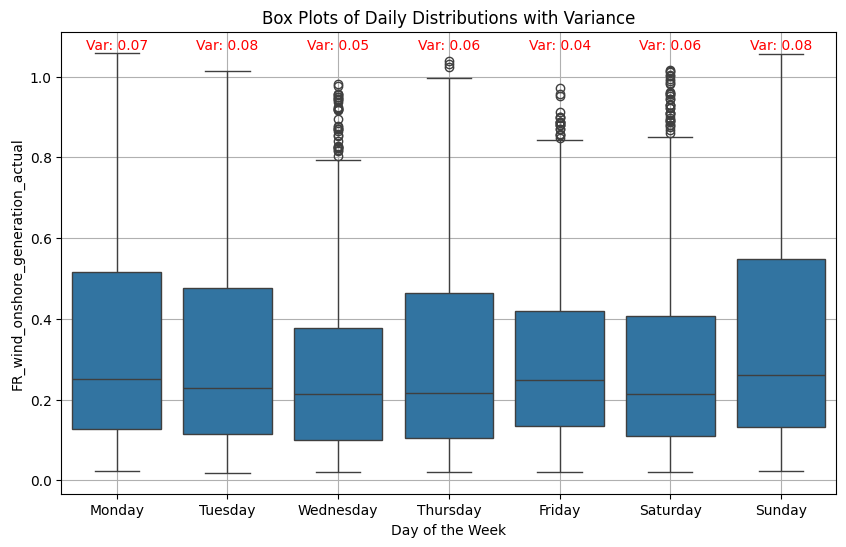

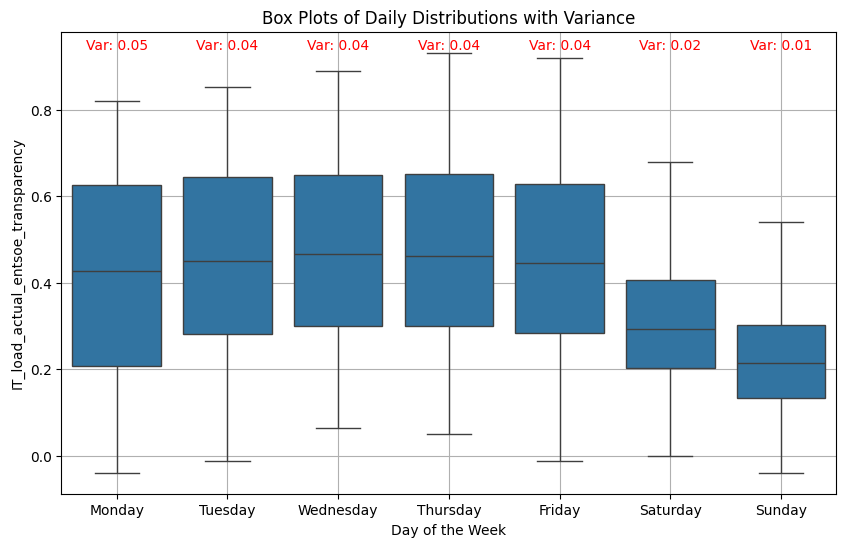

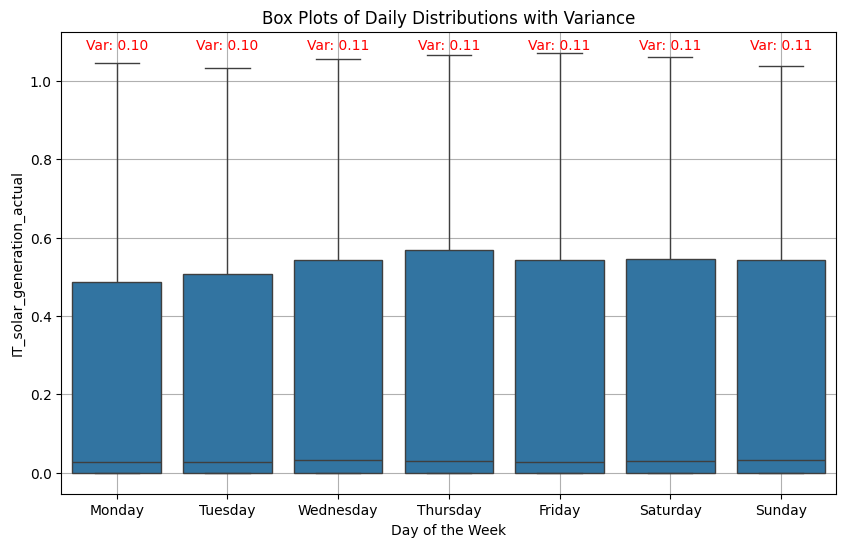

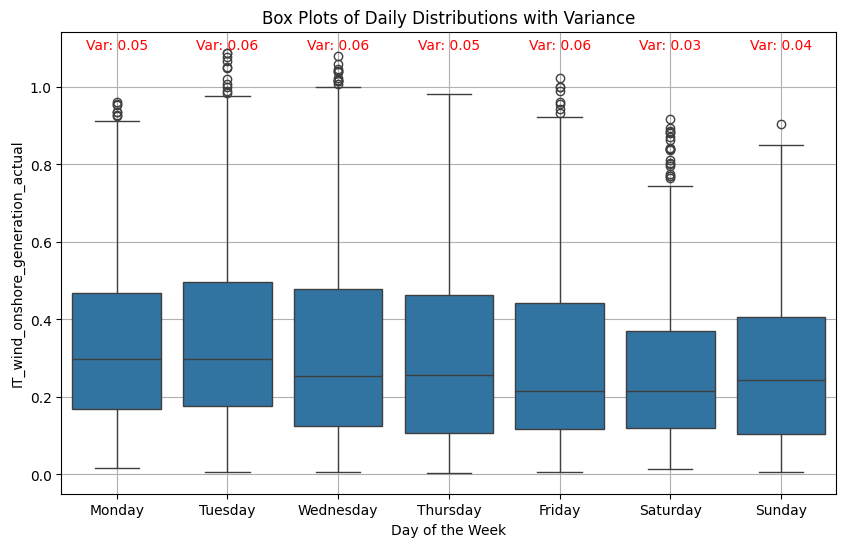

In [22]:
for col in test.columns:
    plot_daily_boxplots(test, col)

In [23]:
# Number of close to zero values
tolerance = 1e-4 
print(f"{'Column name':<40} {'Number of close to zero':>15}")

for col in train.columns[:-2]:
    print(f'{col:<40} {len(train[np.isclose(train[col], 0.0, rtol=tolerance, atol=tolerance)]):>15}')

Column name                              Number of close to zero
DE_load_actual_entsoe_transparency                     1
DE_solar_generation_actual                         13242
DE_wind_generation_actual                              1
DE_wind_offshore_generation_actual                    14
DE_wind_onshore_generation_actual                      1
GB_UKM_load_actual_entsoe_transparency                 1
GB_UKM_solar_generation_actual                     11970
GB_UKM_wind_generation_actual                          1
GB_UKM_wind_offshore_generation_actual                 6
GB_UKM_wind_onshore_generation_actual                  1
ES_load_actual_entsoe_transparency                     1
ES_solar_generation_actual                             4
ES_wind_onshore_generation_actual                      4
FR_load_actual_entsoe_transparency                     2
FR_solar_generation_actual                         13036
FR_wind_onshore_generation_actual                      3
IT_load_actual_entsoe_t

In [24]:
train.describe().loc[['min', '25%', '50%', '75%', 'max']].round(2)

,DE_load_actual_entsoe_transparency,DE_solar_generation_actual,DE_wind_generation_actual,DE_wind_offshore_generation_actual,DE_wind_onshore_generation_actual,GB_UKM_load_actual_entsoe_transparency,GB_UKM_solar_generation_actual,GB_UKM_wind_generation_actual,GB_UKM_wind_offshore_generation_actual,GB_UKM_wind_onshore_generation_actual,ES_load_actual_entsoe_transparency,ES_solar_generation_actual,ES_wind_onshore_generation_actual,FR_load_actual_entsoe_transparency,FR_solar_generation_actual,FR_wind_onshore_generation_actual,IT_load_actual_entsoe_transparency,IT_solar_generation_actual,IT_wind_onshore_generation_actual
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.36,0.00,0.10,0.11,0.09,0.50,0.00,0.16,0.13,0.15,0.30,0.01,0.17,0.24,0.00,0.08,0.28,0.00,0.12
50%,0.54,0.00,0.20,0.30,0.18,0.63,0.01,0.29,0.27,0.28,0.48,0.10,0.29,0.35,0.02,0.15,0.45,0.01,0.25
75%,0.74,0.22,0.36,0.51,0.33,0.71,0.21,0.48,0.47,0.46,0.63,0.44,0.43,0.51,0.30,0.27,0.64,0.38,0.44
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


Differences in distributions between train, validation and test sets.

The most noticeable: 

Germany: wind offshore.

Britain: load.

France: load, wind (not much).

Italy: load.

**Spain: load and solar generation - test set.**

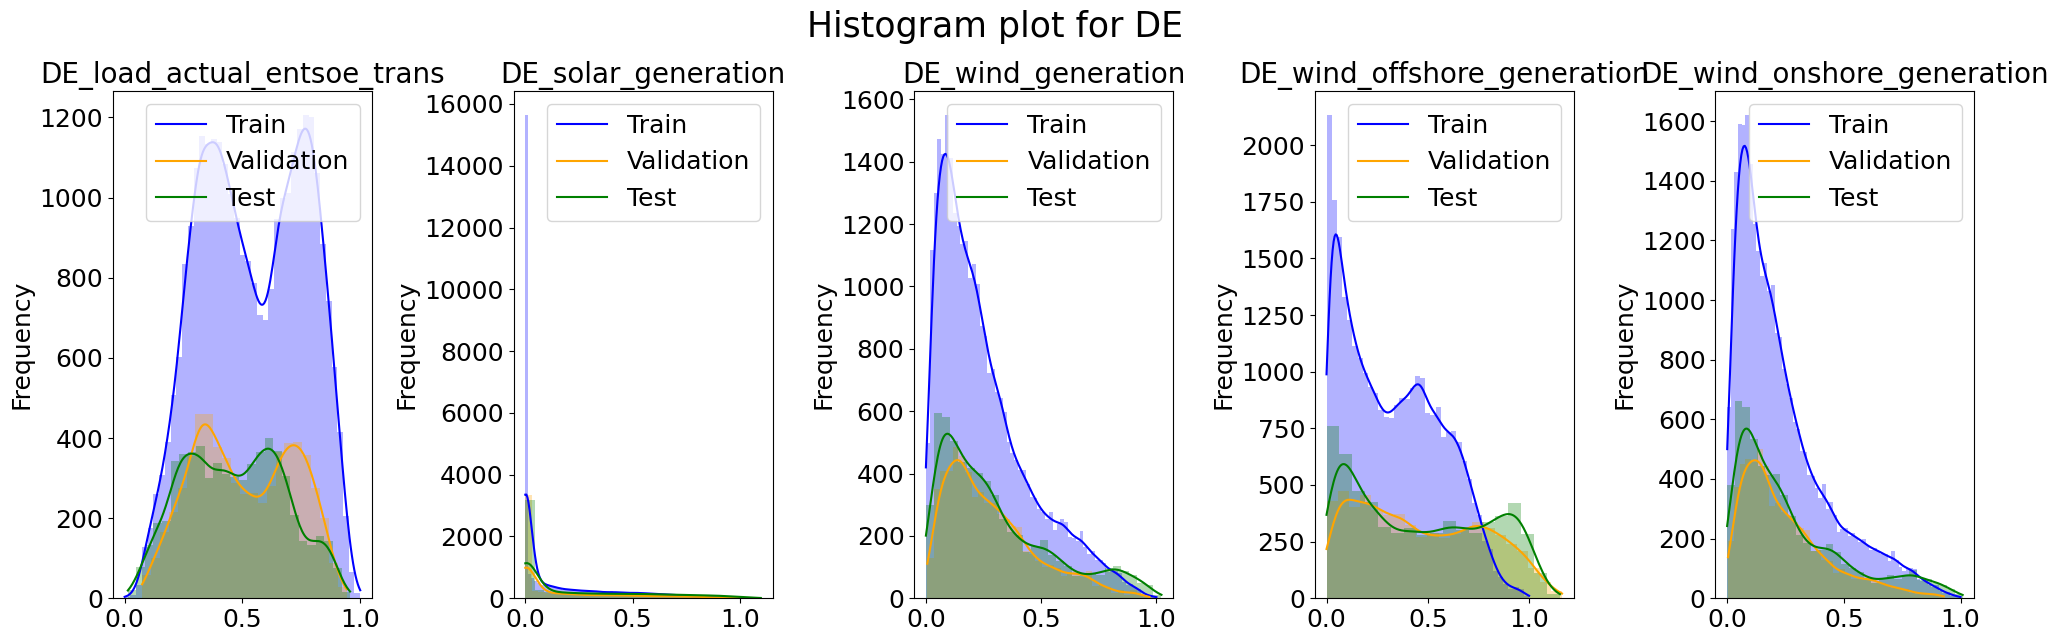

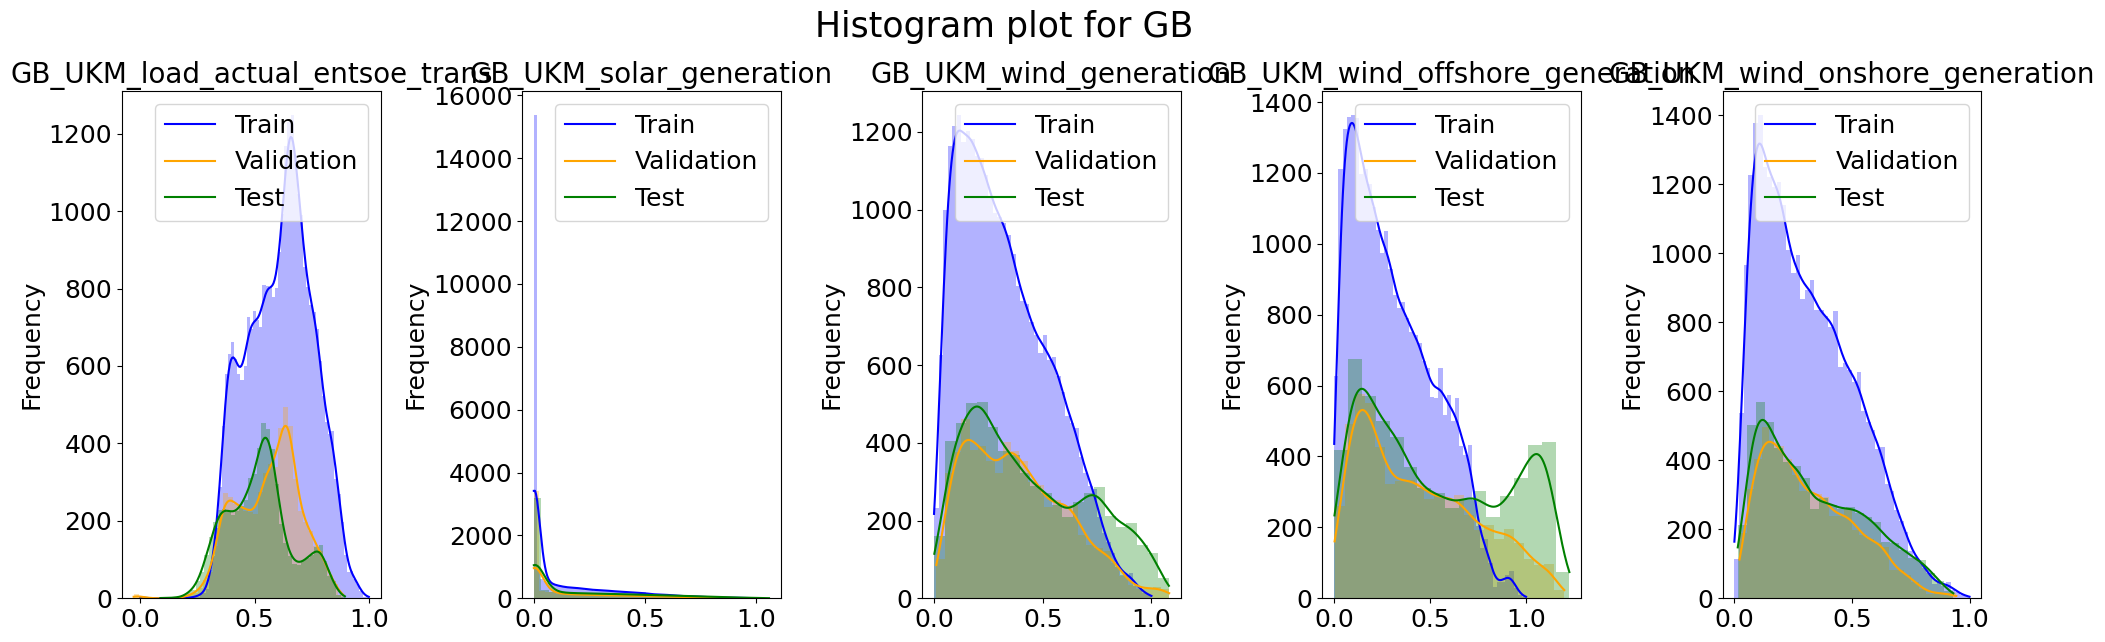

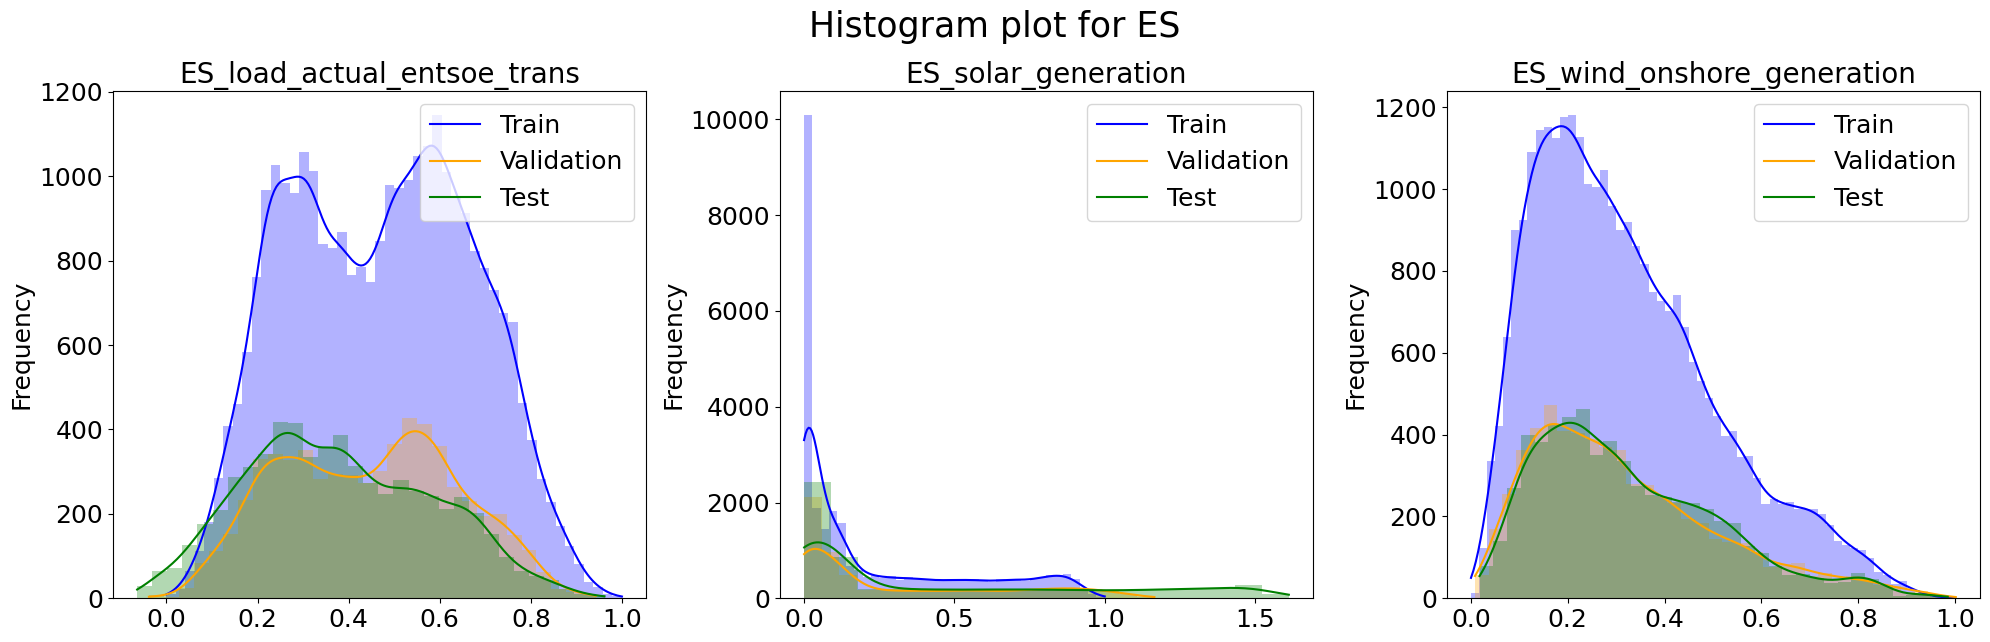

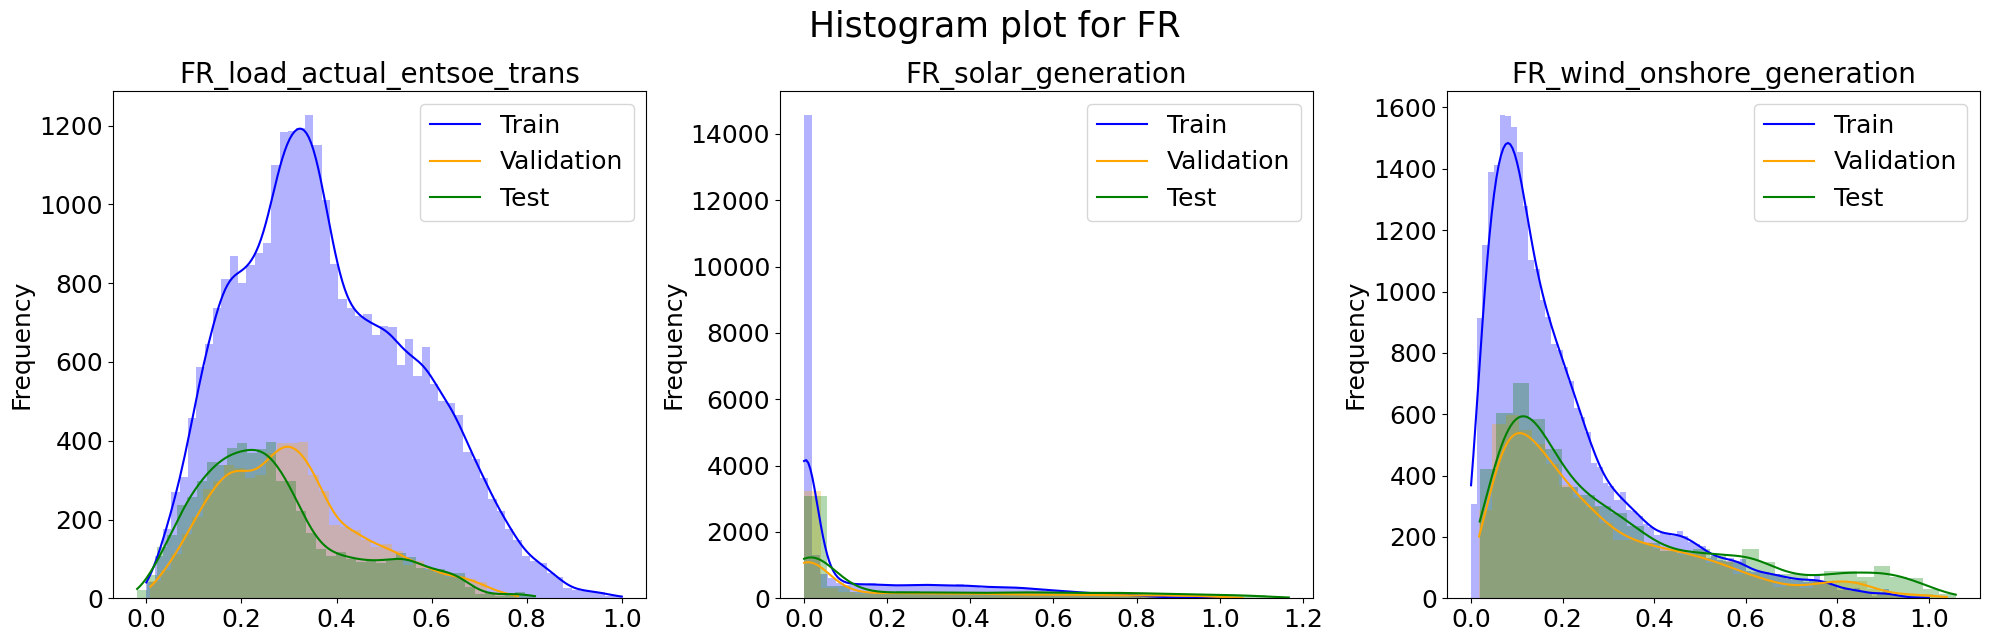

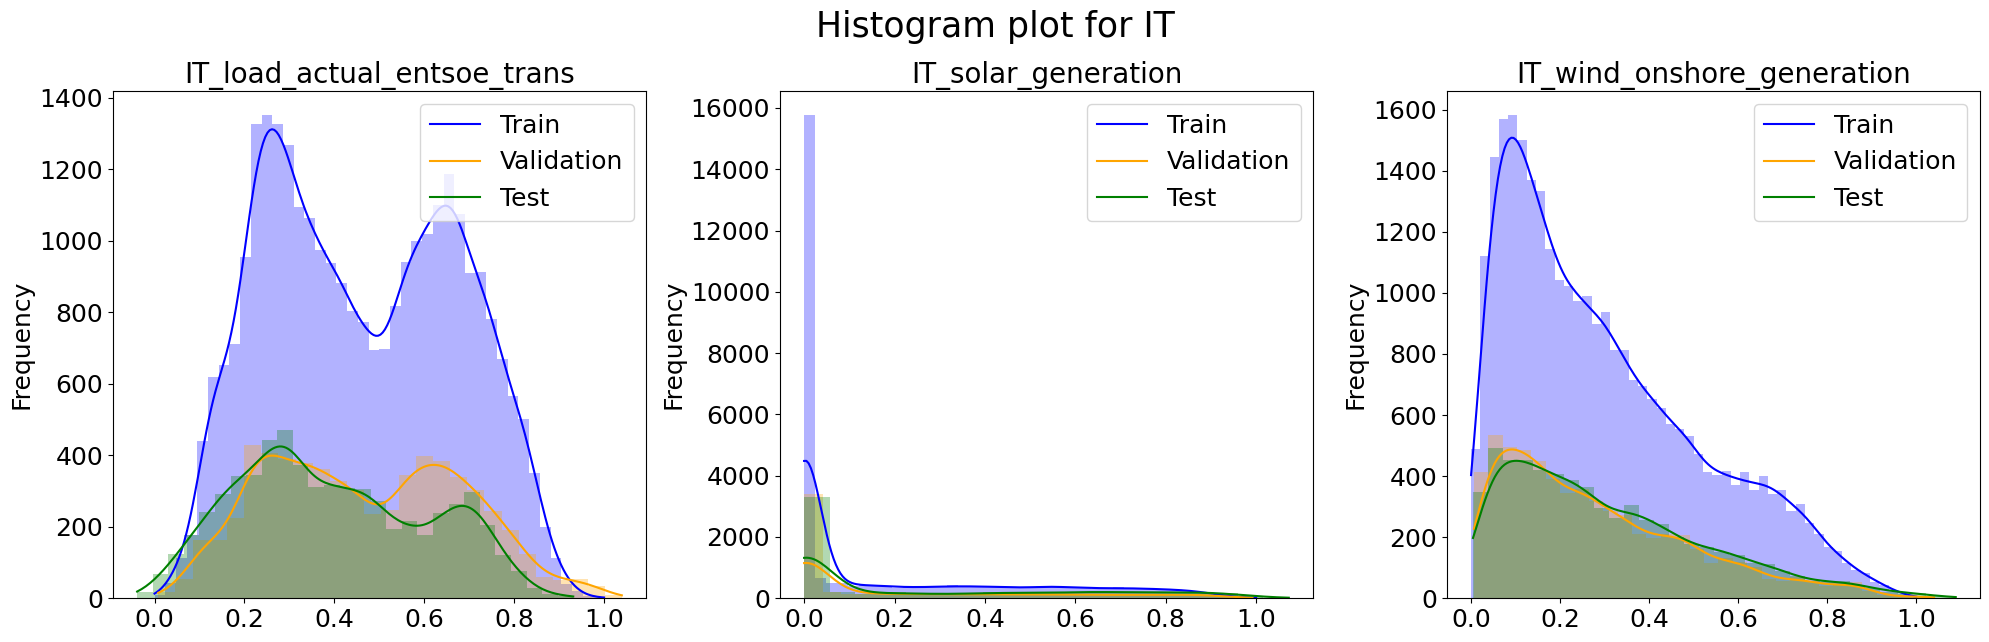

In [25]:
for col in top_5_countries: 

    train_s = train.filter(like=col, axis=1)
    vali_s = vali.filter(like=col, axis=1)
    test_s = test.filter(like=col, axis=1)

    n_cols = len(train_s.columns)
    
    multiple_hist_plots(train_serie=train_s, vali_serie=vali_s, test_serie=test_s, col=col, num_cols=n_cols,
               title = f"Histogram plot for {col}")

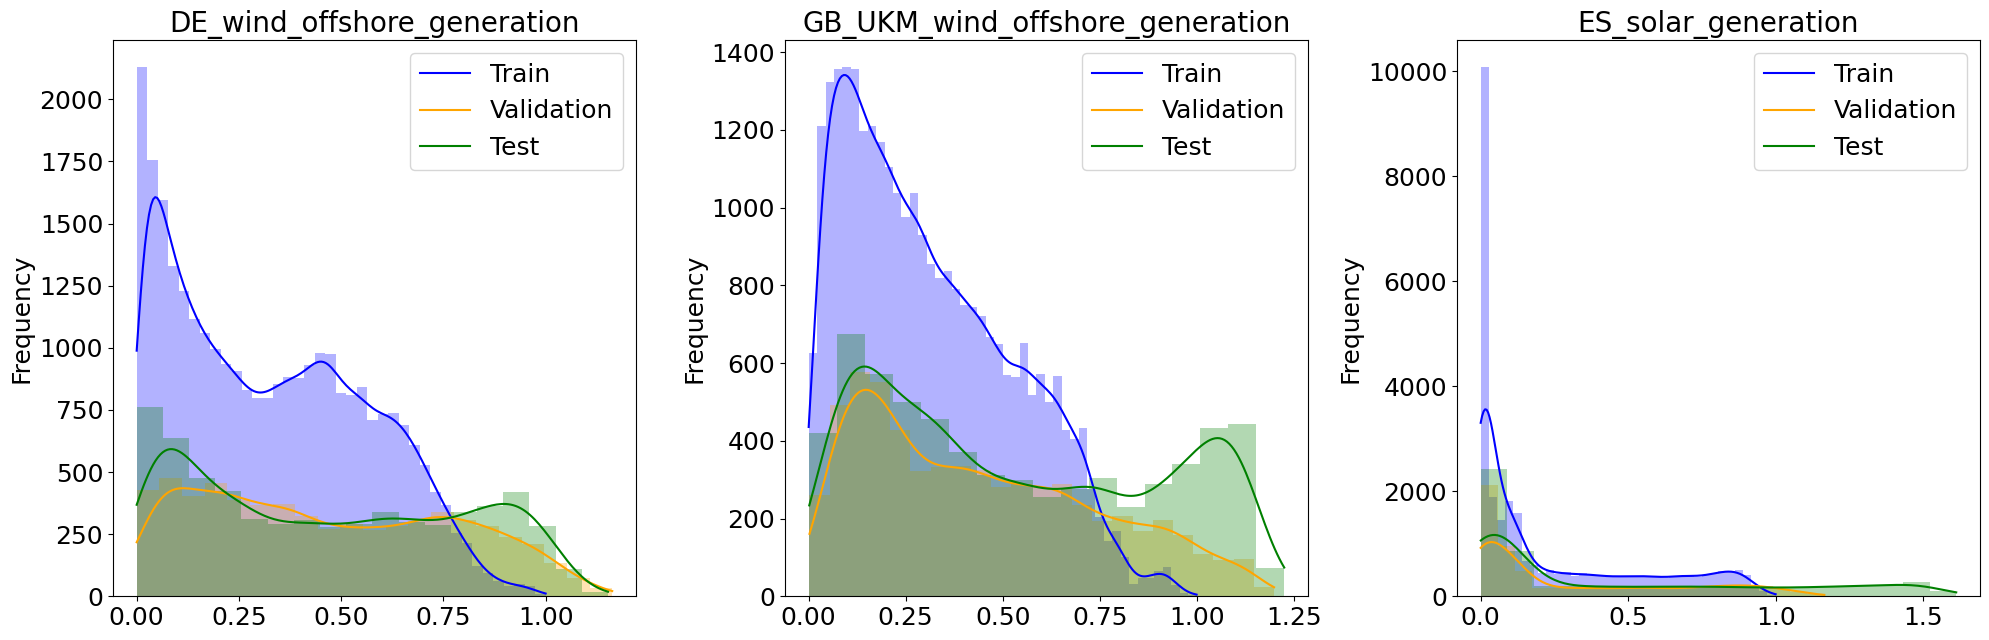

In [26]:
cols = ['DE_wind_offshore_generation_actual', 'GB_UKM_wind_offshore_generation_actual', 'ES_solar_generation_actual']

n_cols = 3

train_s = train[cols]
vali_s = vali[cols]
test_s = test[cols]

multiple_hist_plots(train_serie=train_s, vali_serie=vali_s, test_serie=test_s, num_cols=n_cols)

In [ ]:
train_df = train.copy() 
test_df = test.copy()

train_df['DATA_TYPE'] = 'BASE'
test_df['DATA_TYPE'] = 'TEST'

df_psi = pd.concat([train_df, test_df], axis=0)  

transformer = DropHighPSIFeatures(
    split_col='DATA_TYPE', 
    strategy='equal_frequency',    
    bins=30,                    
    threshold=0.1,             
    missing_values='ignore'    
)

transformer.fit(df_psi)

psi_nums = transformer.psi_values_
pd.DataFrame({"PSI": psi_nums.values()}, index=psi_nums.keys()).sort_values("PSI", ascending=False)


,PSI
GB_UKM_wind_offshore_generation_actual,0.807880
ES_solar_generation_actual,0.661405
GB_UKM_load_actual_entsoe_transparency,0.648694
FR_solar_generation_actual,0.587347
DE_wind_offshore_generation_actual,0.523937
FR_load_actual_entsoe_transparency,0.465506
FR_wind_onshore_generation_actual,0.319554
GB_UKM_wind_generation_actual,0.299366
DE_load_actual_entsoe_transparency,0.252251
ES_load_actual_entsoe_transparency,0.231014


In [ ]:
train_df = test.copy() 
test_df = train.copy()

train_df['DATA_TYPE'] = 'BASE'
test_df['DATA_TYPE'] = 'TEST'

df_psi = pd.concat([train_df, test_df], axis=0)  

transformer = DropHighPSIFeatures(
    split_col='DATA_TYPE', 
    strategy='equal_frequency',    
    bins=30,                    
    threshold=0.1,             
    missing_values='ignore'    
)

transformer.fit(df_psi)

psi_nums = transformer.psi_values_
pd.DataFrame({"PSI": psi_nums.values()}, index=psi_nums.keys()).sort_values("PSI", ascending=False)

,PSI
ES_solar_generation_actual,1.432003
GB_UKM_wind_offshore_generation_actual,1.391066
FR_solar_generation_actual,0.755700
DE_wind_offshore_generation_actual,0.713972
GB_UKM_load_actual_entsoe_transparency,0.652319
FR_load_actual_entsoe_transparency,0.446747
GB_UKM_wind_generation_actual,0.372574
FR_wind_onshore_generation_actual,0.322427
ES_load_actual_entsoe_transparency,0.286745
DE_load_actual_entsoe_transparency,0.250503


In [ ]:
train_df = vali.copy() 
test_df = test.copy()

train_df['DATA_TYPE'] = 'BASE'
test_df['DATA_TYPE'] = 'TEST'

df_psi = pd.concat([train_df, test_df], axis=0)  

transformer.fit(df_psi)

psi_nums = transformer.psi_values_
pd.DataFrame({"PSI": psi_nums.values()}, index=psi_nums.keys()).sort_values("PSI", ascending=False)


,PSI
ES_solar_generation_actual,0.453366
GB_UKM_load_actual_entsoe_transparency,0.330620
FR_solar_generation_actual,0.278315
IT_load_actual_entsoe_transparency,0.200964
GB_UKM_wind_offshore_generation_actual,0.192202
DE_load_actual_entsoe_transparency,0.167230
ES_load_actual_entsoe_transparency,0.157085
GB_UKM_wind_generation_actual,0.147691
FR_load_actual_entsoe_transparency,0.143167
DE_wind_generation_actual,0.118027


In [ ]:
base_df = test.copy() 
test_df = vali.copy()

base_df['DATA_TYPE'] = 'BASE'
test_df['DATA_TYPE'] = 'TEST'

df_psi = pd.concat([base_df, test_df], axis=0)  

transformer.fit(df_psi)

psi_nums = transformer.psi_values_
pd.DataFrame({"PSI": psi_nums.values()}, index=psi_nums.keys()).sort_values("PSI", ascending=False)


,PSI
ES_solar_generation_actual,0.991422
FR_solar_generation_actual,0.336051
GB_UKM_load_actual_entsoe_transparency,0.322306
IT_load_actual_entsoe_transparency,0.206413
GB_UKM_wind_offshore_generation_actual,0.193112
ES_load_actual_entsoe_transparency,0.183597
DE_load_actual_entsoe_transparency,0.169114
GB_UKM_wind_generation_actual,0.151703
FR_load_actual_entsoe_transparency,0.145707
DE_wind_generation_actual,0.129054


In [40]:
combined_df.to_csv("./datasets/combined_data.csv")